In [12]:
"""
Author: Diana Mansurova (5786387)
Inspirared by:
https://www.kaggle.com/deepcnn/mislabeled-training-images 
https://www.kaggle.com/rdokov/exact-duplicates 
"""
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import pandas as pd 
import matplotlib.pyplot as plt
import hashlib

import os
import glob
import shutil
import time 
%matplotlib inline

In [2]:
def extract_data2():
    """
    Extracts images that contain five classes of interest
    Renames images to the following format:
        {class}2_{images_number}.jpeg
    Moves them to a corresponding class folder: flowers/{class}.
    Return:
        flowers - a dictionary with five keys ( 1 sunflower, 2 tulip, 3 rose, 4 dandelion, 5 daisy)
    """

    path_train = "../data/data2/flower_tpu/flower_tpu/flowers_google/flowers_google/"

    imgs = sorted(glob.glob(path_train + "*.jpeg"))
    labels = pd.read_csv("../data/data2/flowers_idx.csv")

    match = {
        'sunflower': 1,
        'common tulip': 2,
        'siam tulip': 2,
        'wild rose': 3,
        'rose': 3,
        'desert-rose': 3,
        'lenten rose': 3,
        'pink primrose': 3,
        'common dandelion': 4,
        'daisy': 5,
        'barberton daisy': 5
    }

    # descripton of the folder numbering
    folder = {
        1: "sunflower",
        2: "tulip",
        3: "rose",
        4: "dandelion",
        5: "daisy"
    }

    data = labels.loc[labels['flower_cls'].isin(list(match.keys()))]
    
    # data.to_csv('data.csv', index=False)
    ids = data['id'].values

    for img in imgs:
        num = int(img[len(path_train):-5])
        if num in ids:
            cl = match[data.loc[data['id'] == num]["flower_cls"].values[0]]
            os.rename(img,  "../data/flowers/" +
                            folder[cl] + 
                            "/" + 
                            folder[cl] + 
                            "2" + "_" + 
                            str(num) + ".jpeg")
    

def extract_data1():
    """
    Renames images to the following format:
        {class}1_{images_number}.jpeg
    Moves them to a corresponding class folder: data/flowers/{class}.
    """
    path = "../data/data1/original-jpegs/"
   
    classes = sorted(glob.glob(path + "*"))
    IDX = 1
    for cl in classes:
        imgs = sorted(glob.glob(cl + "/*.jpg"))
        cl_name = cl[len(path):]
        if cl_name[-1] == "s":
            cl_name = cl_name[:-1]
        for img in imgs:
            os.rename(img,  "../data/flowers/" +
                                cl_name + 
                                "/" + 
                                cl_name + 
                                "1" + "_" + 
                                str(IDX) + ".jpg")
            IDX += 1



def merge_data():
    """
    Merges two datasets and stores them in ../data/flowers/
    """
    # create new folder structure
    if not os.path.exists("../data/flowers/"):
        os.mkdir("../data/flowers/")
    if not os.path.exists("../data/flowers/dandelion/"):
        os.mkdir("../data/flowers/dandelion/")
    if not os.path.exists("../data/flowers/rose/"):
        os.mkdir("../data/flowers/rose/")
    if not os.path.exists("../data/flowers/sunflower/"):
        os.mkdir("../data/flowers/sunflower/")
    if not os.path.exists("../data/flowers/daisy/"):
        os.mkdir("../data/flowers/daisy/")
    if not os.path.exists("../data/flowers/tulip/"):
        os.mkdir("../data/flowers/tulip/")

    # move the License file to the flower/ folder
    if os.path.exists("../data/data1/LICENSE.txt") :
        os.rename("../data/data1/LICENSE.txt", "../data/flowers/LICENSE.txt")

    # Extract data
    extract_data1()
    extract_data2()

    # Delete remaining old folders
    if os.path.exists("../data/data1/"):
        shutil.rmtree("../data/data1/")
    
    if os.path.exists("../data/data2/"):
        shutil.rmtree("../data/data2/")

# Merge two datasets
merge_data()

Number of duplicates:  5
                   filename      class                            md5sum
3252  sunflower2_11097.jpeg  sunflower  2f1cf47477e6ce6ded268c4cb08f31e6
4094   sunflower2_4174.jpeg  sunflower  2f1cf47477e6ce6ded268c4cb08f31e6


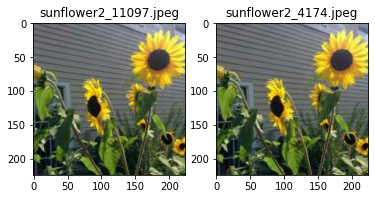

------
                 filename      class                            md5sum
3688  sunflower1_2269.jpg  sunflower  6e42be87cdcb56a3d86a8f10ec3dc724
3741  sunflower1_2270.jpg  sunflower  6e42be87cdcb56a3d86a8f10ec3dc724


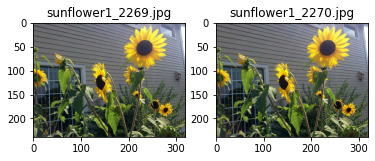

------
             filename  class                            md5sum
2212  tulip1_3121.jpg  tulip  75a3d8ee9f189811e3c1b1730ff7e1f5
6171   rose1_1652.jpg   rose  75a3d8ee9f189811e3c1b1730ff7e1f5


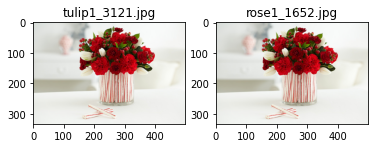

------
                   filename      class                            md5sum
3163   sunflower2_1582.jpeg  sunflower  9494727e7919a4520f3b45a605bb52d0
3304  sunflower2_14261.jpeg  sunflower  9494727e7919a4520f3b45a605bb52d0


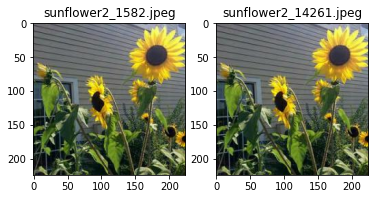

------
                 filename      class                            md5sum
3544  sunflower1_2268.jpg  sunflower  c2c25e7d56294d6463c925adbf3df3e4
4045  sunflower1_2241.jpg  sunflower  c2c25e7d56294d6463c925adbf3df3e4


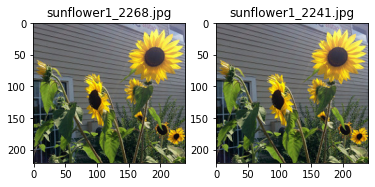

------


In [5]:
def remove_exact_duplicates():
    """
    removes the completely identical images using the md5sum hash
    Adapted from https://www.kaggle.com/rdokov/exact-duplicates  
    """
    records = []

    path = '../data/flowers/'
    dirs =  glob.glob(path + "*/")
    for cl in dirs:
        cl = cl[len(path):-1]
        for img in  os.listdir(path + cl):
            
            with open(path + cl + "/" + img, 'rb') as fd:
                md5sum = hashlib.md5(fd.read()).hexdigest()

            records.append({
                'filename': img,
                'class': cl,
                'md5sum': md5sum,
            })

    df = pd.DataFrame.from_records(records)


    counts = df.groupby('md5sum')['class'].count()
    duplicates = counts[counts > 1]
    print("Number of duplicates: ", len(duplicates))

    # print(duplicates)
    for md5sum in duplicates.index:
        subset = df[df['md5sum'] == md5sum]
        print(subset)
        if len(subset['filename'].value_counts()) > 1:
            
            img1_name = path + subset.iloc[0, 1] + "/" + subset.iloc[0, 0]
            img2_name = path + subset.iloc[1, 1] + "/" + subset.iloc[1, 0]

            # visualize duplicates
            img1 = cv2.cvtColor(cv2.imread(img1_name), cv2.COLOR_BGR2RGB)
            img2 = cv2.cvtColor(cv2.imread(img2_name), cv2.COLOR_BGR2RGB)
            
            fig = plt.figure()
            fig.add_subplot(121)
            plt.title(subset.iloc[0, 0])
            plt.imshow(img1)

            fig.add_subplot(122)
            plt.title(subset.iloc[1, 0])
            plt.imshow(img2)

            plt.show()
            
            if os.path.exists(img1_name):
                os.remove(img1_name)
            if os.path.exists(img2_name):
                os.remove(img2_name)

            print('------')

remove_exact_duplicates()

In [14]:
def crop_to_square(img, resolution=256):
    """
    crops image to a square format (256 x 256)
    """
    h, w = img.shape[:2]

    left = 0
    right = w
    top = 0
    bottom = h 

    half_w = w // 2
    half_h = h // 2

    if h > w:
        left = 0
        right = w
        top = half_h - half_w
        bottom = half_h + half_w

        if bottom - top > right:
            bottom -=  bottom - top - right
        elif bottom - top < right:
            bottom +=  right - (bottom - top)

    elif w > h:
        left = half_w - half_h
        right = half_w + half_h
        top = 0
        bottom = h 

        if right - left > bottom:
            right -=  right - left - bottom
        elif right - left < bottom:
            right += bottom - (right - left)
    
    img = cv2.resize(img[top:bottom, left:right], (resolution, resolution))
    return img


def load_data():
    """
    Loads the entire dataset in a list, where each image has a specified resolution
    """
    path = "../data/flowers/"
    clss = glob.glob(path + "*/")
    
    images = []
    names = []
    classes = []

    for cl in clss:
        imgs = glob.glob(cl + "*.j*")
        for img in imgs:
            classes += [cl[len(path):-1]]
            images += [crop_to_square(cv2.imread(img, 0), resolution=100)]
            names += [img[len(cl):]]
    return images, names, classes
    
images, names, classes = load_data()
len(images), len(names), len(classes)

(8172, 8172, 8172)

In [8]:
def mse(img1, img2):
    err = np.sum((img1 - img2) ** 2)
    err /= float(img1.shape[0] * img2.shape[1])

    # return the MSE, the lower the error, the more "similar"
    # the two images are
    return err


def find_pairs(compare_img, compare_idx, images, names, matches):
    """ 
    Find all paired duplicates
    Adapted from https://www.kaggle.com/deepcnn/mislabeled-training-images 
    """
    threshold = 90 # less than 10% difference
    for idx, img in enumerate(images):
        if idx <= compare_idx:
            continue
        else:
            if (1 - mse(compare_img, img))*100 >= threshold \
            and idx != compare_idx:
                matches.append((names[compare_idx], names[idx]))
    return matches

t0 = time.time()
matches = []
for idx, img in enumerate(images):
    matches = find_pairs(img, idx, images, names, matches)   
    if idx % 100 == 0:
        print(idx)
        print(matches)
print(len(matches))
print(matches)
print("Time elapsed: ", time.time() - t0)


0
[]
100
[]
200
[]
300
[]
400
[]
500
[]
600
[]
700
[]
800
[]
900
[]
1000
[]
1100
[]
1200
[]
1300
[]
1400
[]
1500
[]
1600
[]
1700
[]
1800
[]
1900
[]
2000
[]
2100
[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
2200
[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
2300
[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
2400
[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
2500
[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
2600
[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
2700
[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
2800
[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
2900
[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
3000
[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
3100
[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
3200
[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
3300
[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
3400
[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
3500
[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
3600
[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
3700
[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
3800
[('tulip2_7408.jpeg', '

In [9]:
print(matches)
print(len(matches))

[('tulip2_7408.jpeg', 'tulip2_2457.jpeg')]
1


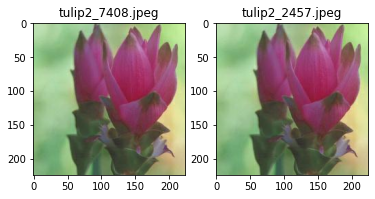

In [10]:
def remove_duplicates(matches, visualize=True):
    """
    removes all duplicates found by the function "find_pairs"
    visualizes them pairwise by setting the param "visualize" to True.
    """
    for (path1, path2) in matches:
        if "tulip" in path1:
            img1 = "../data/flowers/tulip/" + path1
        elif "sunflower" in path1:
            img1 = "../data/flowers/sunflower/" + path1
        elif "daisy" in path1:
            img1 = "../data/flowers/daisy/" + path1
        elif "rose" in path1:
            img1 = "../data/flowers/rose/" + path1
        else:
            img1 = "../data/flowers/dandelion/" + path1

        if "tulip" in path2:
            img2 = "../data/flowers/tulip/" + path2
        elif "sunflower" in path2:
            img2 = "../data/flowers/sunflower/" + path2
        elif "daisy" in path2:
            img2 = "../data/flowers/daisy/" + path2
        elif "rose" in path2:
            img2 = "../data/flowers/rose/" + path2
        else:
            img2 = "../data/flowers/dandelion/" + path2

        if visualize:
            im1 = cv2.cvtColor(cv2.imread(img1), cv2.COLOR_BGR2RGB)
            im2 = cv2.cvtColor(cv2.imread(img2), cv2.COLOR_BGR2RGB)
            fig = plt.figure()
            fig.add_subplot(121)
            plt.title(path1)
            plt.imshow(im1)

            fig.add_subplot(122)
            plt.title(path2)
            plt.imshow(im2)
            plt.show()
        if os.path.exists(img1):
            os.remove(img1)
        if os.path.exists(img2):
            os.remove(img2)

            
remove_duplicates(matches, visualize=True)

In [15]:
# Prepare splitting of the dataset into training and testing sets with respect to the ratios 80:20
def create_new_folder_structure():
    # create new folder structure
    if not os.path.exists("../data/flowers/train/"):
        os.mkdir("../data/flowers/train/")
    if not os.path.exists("../data/flowers/train/dandelion/"):
        os.mkdir("../data/flowers/train/dandelion/")
    if not os.path.exists("../data/flowers/train/rose/"):
        os.mkdir("../data/flowers/train/rose/")
    if not os.path.exists("../data/flowers/train/sunflower/"):
        os.mkdir("../data/flowers/train/sunflower/")
    if not os.path.exists("../data/flowers/train/daisy/"):
        os.mkdir("../data/flowers/train/daisy/")
    if not os.path.exists("../data/flowers/train/tulip/"):
        os.mkdir("../data/flowers/train/tulip/")

    if not os.path.exists("../data/flowers/test/"):
        os.mkdir("../data/flowers/test/")
    if not os.path.exists("../data/flowers/test/dandelion/"):
        os.mkdir("../data/flowers/test/dandelion/")
    if not os.path.exists("../data/flowers/test/rose/"):
        os.mkdir("../data/flowers/test/rose/")
    if not os.path.exists("../data/flowers/test/sunflower/"):
        os.mkdir("../data/flowers/test/sunflower/")
    if not os.path.exists("../data/flowers/test/daisy/"):
        os.mkdir("../data/flowers/test/daisy/")
    if not os.path.exists("../data/flowers/test/tulip/"):
        os.mkdir("../data/flowers/test/tulip/")


def split_dataset():
    """ 
    Slpit the entire dataset into training and testing set
    """
    create_new_folder_structure()
    path = "../data/flowers/"
    tulip = glob.glob(path + "tulip/*.j*")
    sunflower = glob.glob(path + "sunflower/*.j*")
    rose = glob.glob(path + "rose/*.j*")
    dandelion = glob.glob(path + "dandelion/*.j*")
    daisy = glob.glob(path + "daisy/*.j*")
    flowers = [tulip, daisy, sunflower, rose, dandelion]

    minimum_size= min([len(daisy), len(dandelion), len(rose), len(sunflower), len(tulip) ])
    
    for i in range(0,3):
        for fl in flowers:
            np.random.seed(42)
            np.random.shuffle(fl)

    for idx, fl in enumerate(flowers):
        fl = fl[:minimum_size]
        X_train, X_test = train_test_split(fl, test_size=0.2, shuffle=True, random_state=42)
        
        # relocate the training set
        for sample in X_train:
            img = crop_to_square(cv2.imread(sample), resolution=256)
            cv2.imwrite("../data/flowers/train/" + sample[len(path):], img)
        # relocate the testing set
        for sample in X_test:
            img = crop_to_square(cv2.imread(sample), resolution=256)
            cv2.imwrite("../data/flowers/test/" + sample[len(path):], img)    
    
    # remove unnecessary folders
    if os.path.exists("../data/flowers/daisy/"):
        shutil.rmtree("../data/flowers/daisy/")
    if os.path.exists("../data/flowers/sunflower/"):
        shutil.rmtree("../data/flowers/sunflower/")
    if os.path.exists("../data/flowers/rose/"):
        shutil.rmtree("../data/flowers/rose/")
    if os.path.exists("../data/flowers/tulip/"):
        shutil.rmtree("../data/flowers/tulip/")
    if os.path.exists("../data/flowers/dandelion/"):
        shutil.rmtree("../data/flowers/dandelion/")
        
split_dataset()
